# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized (per layer)( calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images, developing a separate NN per calo layer).
2. Simple combinations (via a new NN, or combined single deep NN) of the flattened NNs from above.
3. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
4. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plotpath = '/home/mswiatlowski/start_tf/caloml-atlas/classifier/Plots/'
modelpath = '/home/mswiatlowski/start_tf/caloml-atlas/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [2]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:2
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:3
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:4
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:5
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:6
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:7
INFO:tensorflow:Device is available but not used by distribute strategy: /device:GPU:4
INFO:te

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [3]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)
path = '/fast_scratch/atlas_images/v5/'
#path = '/eos/user/m/mswiatlo/images/'

# TODO fix input files so that it is easier to split up the events
p0 = np.load(path+"pi0.npz")
pp = np.load(path+"piplus.npz")
pm = np.load(path+"piminus.npz")

#clean up to round numbers, which are prefered by tf.keras
#don't actually need this
# p0d = {}
# p0d = {key:p0[key][:180000] for key in p0}
# # p0=p0d

# ppd = {}
# ppd = {key:pp[key][:180000] for key in pp}
# # pp=ppd

# pmd = {}
# pmd = {key:pm[key][:280000] for key in pm}
# pm=pmd

# pc = {}
#concat pp and pm for/ greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}
# pp = pc # naughty, just replace it so we don't have to change code later

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 228212
Number of pi+ events: 283984
Number of pi- events: 254028
Total: 766224


### Plot a few example images

<Figure size 432x288 with 0 Axes>

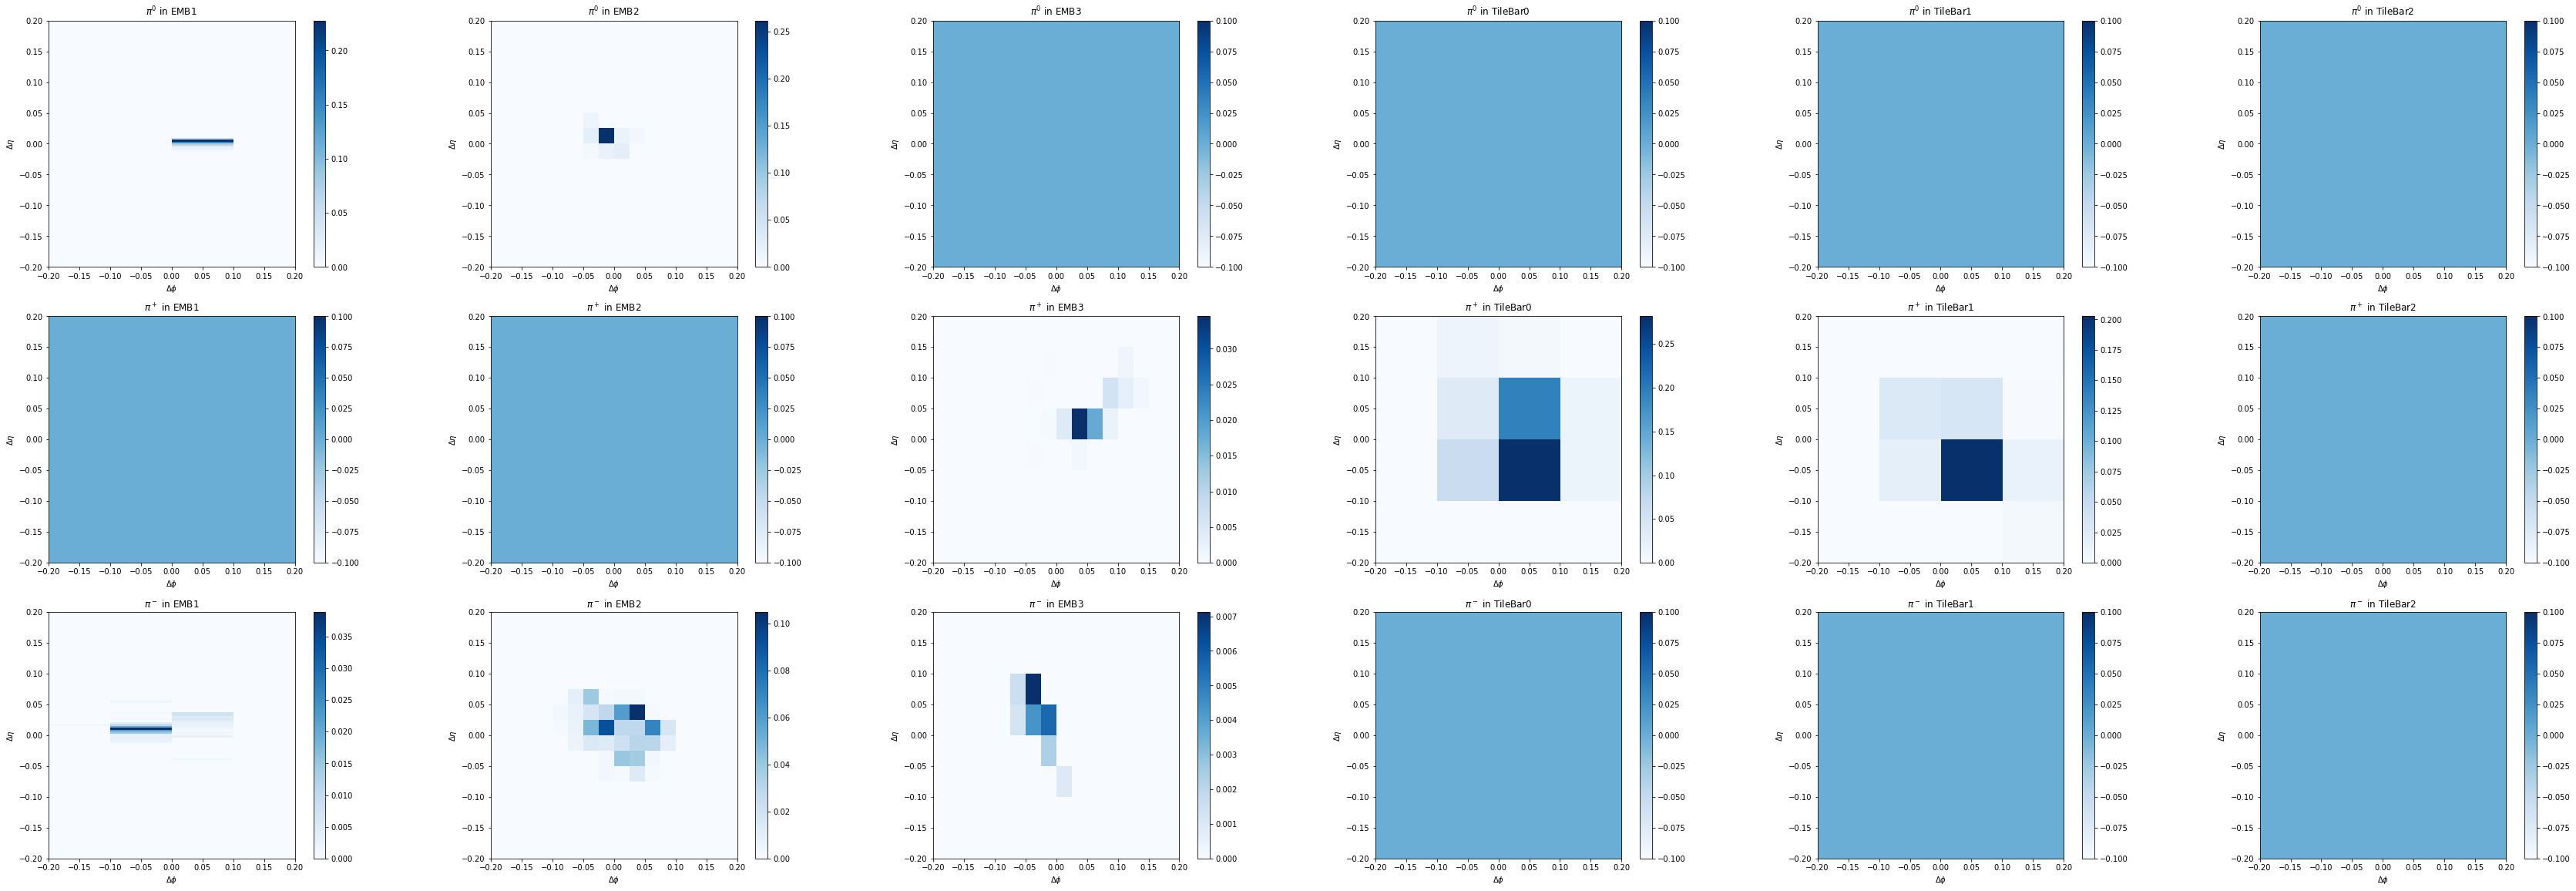

In [4]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi+
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi-
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig(plotpath+'/plots_pi0_plus_minus.pdf')
plt.show()


### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

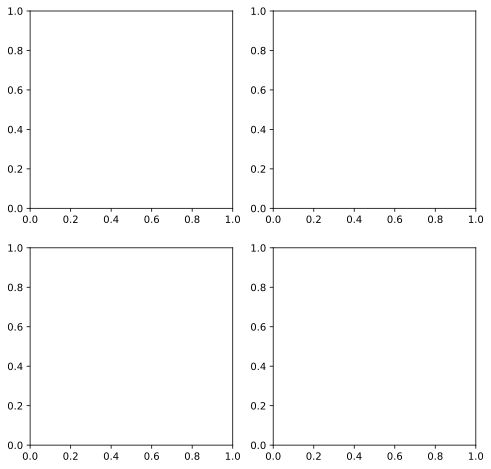

In [86]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: Mat

<Figure size 432x288 with 0 Axes>

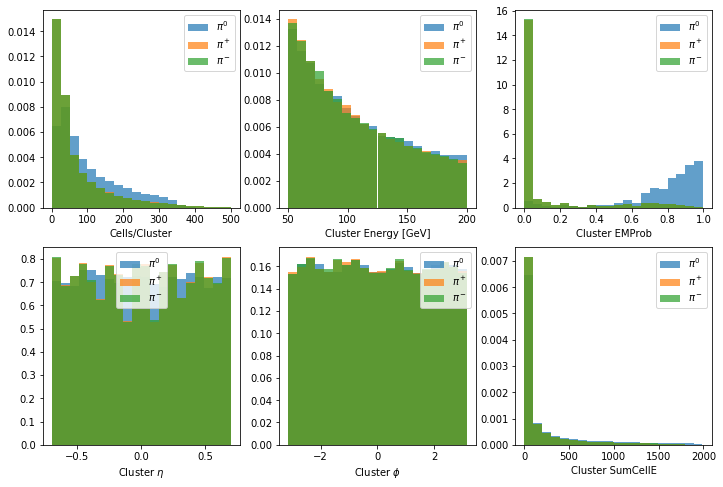

In [5]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
# ax[0,0].text(0.6,0.5,'ATLAS Internal',transform=ax[0,0].transAxes)
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# cluster EM prob
ax[0,2].hist(p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[0,2].hist(pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[0,2].hist(pm['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[0,2].set_xlabel('Cluster EMProb')
ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.savefig(plotpath+'hist_pi0_plus_minus.pdf')
plt.show()


## 1. Simple feed-forward Neural Network

In [8]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# here, define a function to flatten inputs
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [9]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(512196, 512)
(512196, 1)
(512196, 256)
(512196, 1)
(512196, 128)
(512196, 1)
(512196, 16)
(512196, 1)
(512196, 16)
(512196, 1)
(512196, 8)
(512196, 1)


In [10]:
#split up data into separate training, validation, and testing

test_size = 24000
validation_size = 24000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from keras.utils import np_utils
    y_tr_onehot = np_utils.to_categorical(y_tr, 2)
    y_te_onehot = np_utils.to_categorical(y_te, 2)
    y_vl_onehot = np_utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [11]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

Using TensorFlow backend.


y_train.shape:  (464196, 1)
y_train_onehot.shape:  (464196, 2)
y_train.shape:  (464196, 1)
y_train_onehot.shape:  (464196, 2)
y_train.shape:  (464196, 1)
y_train_onehot.shape:  (464196, 2)
y_train.shape:  (464196, 1)
y_train_onehot.shape:  (464196, 2)
y_train.shape:  (464196, 1)
y_train_onehot.shape:  (464196, 2)
y_train.shape:  (464196, 1)
y_train_onehot.shape:  (464196, 2)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [10]:
# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        optimizer = Adam(lr=5e-5)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [11]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_17 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                

In [12]:
# now automated with functions
history_flat = {}
scores = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer %s' % (layer_name))
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 200, batch_size = 200*ngpu, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print('Finished layer %s' % (layer_name))

On layer EMB1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl,num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
Epoch 1/200
291/291 - 12s - loss: 0.6002 - acc: 0.8076 - val_loss: 0.4575 - val_acc: 0.8186
Epoch 2/200
291/291 - 4s - loss: 0.4123 - acc: 0.8338 - val_loss: 0.3868 - val_acc: 0.8442
Epoch 3/200
291/291 - 4s - loss: 0.3757 - acc: 0.8498 - val_loss: 0.3674 - val_acc: 0.8529
Epoch 4/200
291/291 - 4s - loss: 0.3584 - acc: 0.8591 - val_loss: 0.3530 - val_acc: 0.8614
Epoch 5/200
291/291 - 4s - loss: 0.3474 - acc: 0.8659 - val_loss: 0.3453 - val_acc: 0.8670
Epoch 6/200
291/291 - 4s - loss: 0.3418 - acc: 0.8693 - val_loss: 0.3416 - val_acc: 0.8687
Epoch 7/200
291/291 - 4s - loss: 0.3377 - acc: 0.8715 - val_loss: 0.3392 - val_acc: 0.8702
Epoch 8/200
291/291 - 4s - loss: 0.3355 - acc: 0.8726 - val_loss: 0.3368 - val_acc: 0.8714
Epoch 9/200
291/291 - 4s - loss: 0.3333 - acc: 0.8736 - val_loss: 0.3347 - val_acc: 0.8720
Epoch 10/200
291

Epoch 89/200
291/291 - 4s - loss: 0.2118 - acc: 0.9232 - val_loss: 0.2277 - val_acc: 0.9170
Epoch 90/200
291/291 - 4s - loss: 0.2116 - acc: 0.9233 - val_loss: 0.2278 - val_acc: 0.9173
Epoch 91/200
291/291 - 4s - loss: 0.2114 - acc: 0.9235 - val_loss: 0.2284 - val_acc: 0.9170
Epoch 92/200
291/291 - 4s - loss: 0.2112 - acc: 0.9238 - val_loss: 0.2268 - val_acc: 0.9175
Epoch 93/200
291/291 - 4s - loss: 0.2106 - acc: 0.9235 - val_loss: 0.2268 - val_acc: 0.9177
Epoch 94/200
291/291 - 4s - loss: 0.2105 - acc: 0.9235 - val_loss: 0.2268 - val_acc: 0.9185
Epoch 95/200
291/291 - 4s - loss: 0.2103 - acc: 0.9241 - val_loss: 0.2271 - val_acc: 0.9173
Epoch 96/200
291/291 - 4s - loss: 0.2096 - acc: 0.9241 - val_loss: 0.2264 - val_acc: 0.9172
Epoch 97/200
291/291 - 4s - loss: 0.2097 - acc: 0.9242 - val_loss: 0.2263 - val_acc: 0.9179
Epoch 98/200
291/291 - 4s - loss: 0.2094 - acc: 0.9241 - val_loss: 0.2260 - val_acc: 0.9180
Epoch 99/200
291/291 - 4s - loss: 0.2089 - acc: 0.9241 - val_loss: 0.2262 - val_

Epoch 178/200
291/291 - 4s - loss: 0.1945 - acc: 0.9302 - val_loss: 0.2223 - val_acc: 0.9200
Epoch 179/200
291/291 - 4s - loss: 0.1942 - acc: 0.9302 - val_loss: 0.2224 - val_acc: 0.9202
Epoch 180/200
291/291 - 4s - loss: 0.1941 - acc: 0.9299 - val_loss: 0.2237 - val_acc: 0.9199
Epoch 181/200
291/291 - 4s - loss: 0.1942 - acc: 0.9303 - val_loss: 0.2214 - val_acc: 0.9204
Epoch 182/200
291/291 - 4s - loss: 0.1937 - acc: 0.9302 - val_loss: 0.2220 - val_acc: 0.9202
Epoch 183/200
291/291 - 4s - loss: 0.1934 - acc: 0.9307 - val_loss: 0.2214 - val_acc: 0.9213
Epoch 184/200
291/291 - 4s - loss: 0.1934 - acc: 0.9305 - val_loss: 0.2212 - val_acc: 0.9209
Epoch 185/200
291/291 - 4s - loss: 0.1936 - acc: 0.9305 - val_loss: 0.2219 - val_acc: 0.9202
Epoch 186/200
291/291 - 4s - loss: 0.1934 - acc: 0.9303 - val_loss: 0.2235 - val_acc: 0.9202
Epoch 187/200
291/291 - 4s - loss: 0.1930 - acc: 0.9306 - val_loss: 0.2211 - val_acc: 0.9212
Epoch 188/200
291/291 - 4s - loss: 0.1926 - acc: 0.9310 - val_loss: 0.

Epoch 63/200
291/291 - 4s - loss: 0.2363 - acc: 0.9059 - val_loss: 0.2355 - val_acc: 0.9066
Epoch 64/200
291/291 - 4s - loss: 0.2359 - acc: 0.9067 - val_loss: 0.2353 - val_acc: 0.9065
Epoch 65/200
291/291 - 4s - loss: 0.2346 - acc: 0.9067 - val_loss: 0.2340 - val_acc: 0.9067
Epoch 66/200
291/291 - 4s - loss: 0.2345 - acc: 0.9068 - val_loss: 0.2339 - val_acc: 0.9071
Epoch 67/200
291/291 - 4s - loss: 0.2341 - acc: 0.9068 - val_loss: 0.2330 - val_acc: 0.9080
Epoch 68/200
291/291 - 4s - loss: 0.2329 - acc: 0.9077 - val_loss: 0.2318 - val_acc: 0.9081
Epoch 69/200
291/291 - 4s - loss: 0.2326 - acc: 0.9076 - val_loss: 0.2309 - val_acc: 0.9081
Epoch 70/200
291/291 - 4s - loss: 0.2321 - acc: 0.9079 - val_loss: 0.2307 - val_acc: 0.9082
Epoch 71/200
291/291 - 4s - loss: 0.2308 - acc: 0.9087 - val_loss: 0.2297 - val_acc: 0.9091
Epoch 72/200
291/291 - 4s - loss: 0.2306 - acc: 0.9088 - val_loss: 0.2292 - val_acc: 0.9093
Epoch 73/200
291/291 - 4s - loss: 0.2300 - acc: 0.9088 - val_loss: 0.2298 - val_

Epoch 152/200
291/291 - 4s - loss: 0.2036 - acc: 0.9210 - val_loss: 0.2049 - val_acc: 0.9200
Epoch 153/200
291/291 - 4s - loss: 0.2034 - acc: 0.9214 - val_loss: 0.2043 - val_acc: 0.9203
Epoch 154/200
291/291 - 4s - loss: 0.2033 - acc: 0.9210 - val_loss: 0.2046 - val_acc: 0.9206
Epoch 155/200
291/291 - 4s - loss: 0.2027 - acc: 0.9212 - val_loss: 0.2049 - val_acc: 0.9206
Epoch 156/200
291/291 - 4s - loss: 0.2029 - acc: 0.9214 - val_loss: 0.2044 - val_acc: 0.9200
Epoch 157/200
291/291 - 4s - loss: 0.2021 - acc: 0.9215 - val_loss: 0.2043 - val_acc: 0.9200
Epoch 158/200
291/291 - 4s - loss: 0.2026 - acc: 0.9214 - val_loss: 0.2045 - val_acc: 0.9202
Epoch 159/200
291/291 - 4s - loss: 0.2021 - acc: 0.9215 - val_loss: 0.2043 - val_acc: 0.9202
Epoch 160/200
291/291 - 4s - loss: 0.2021 - acc: 0.9217 - val_loss: 0.2045 - val_acc: 0.9203
Epoch 161/200
291/291 - 4s - loss: 0.2015 - acc: 0.9217 - val_loss: 0.2035 - val_acc: 0.9204
Epoch 162/200
291/291 - 4s - loss: 0.2018 - acc: 0.9220 - val_loss: 0.

Epoch 37/200
291/291 - 4s - loss: 0.4343 - acc: 0.7875 - val_loss: 0.4300 - val_acc: 0.7895
Epoch 38/200
291/291 - 4s - loss: 0.4331 - acc: 0.7885 - val_loss: 0.4296 - val_acc: 0.7947
Epoch 39/200
291/291 - 4s - loss: 0.4319 - acc: 0.7884 - val_loss: 0.4260 - val_acc: 0.7936
Epoch 40/200
291/291 - 4s - loss: 0.4315 - acc: 0.7882 - val_loss: 0.4280 - val_acc: 0.7845
Epoch 41/200
291/291 - 4s - loss: 0.4295 - acc: 0.7897 - val_loss: 0.4244 - val_acc: 0.7914
Epoch 42/200
291/291 - 4s - loss: 0.4285 - acc: 0.7897 - val_loss: 0.4227 - val_acc: 0.7937
Epoch 43/200
291/291 - 4s - loss: 0.4273 - acc: 0.7902 - val_loss: 0.4213 - val_acc: 0.7934
Epoch 44/200
291/291 - 4s - loss: 0.4261 - acc: 0.7907 - val_loss: 0.4222 - val_acc: 0.7968
Epoch 45/200
291/291 - 4s - loss: 0.4250 - acc: 0.7908 - val_loss: 0.4205 - val_acc: 0.7977
Epoch 46/200
291/291 - 4s - loss: 0.4235 - acc: 0.7920 - val_loss: 0.4201 - val_acc: 0.7974
Epoch 47/200
291/291 - 4s - loss: 0.4237 - acc: 0.7918 - val_loss: 0.4216 - val_

Epoch 126/200
291/291 - 4s - loss: 0.3890 - acc: 0.8064 - val_loss: 0.3888 - val_acc: 0.8112
Epoch 127/200
291/291 - 4s - loss: 0.3874 - acc: 0.8073 - val_loss: 0.3883 - val_acc: 0.8106
Epoch 128/200
291/291 - 4s - loss: 0.3884 - acc: 0.8063 - val_loss: 0.3873 - val_acc: 0.8103
Epoch 129/200
291/291 - 4s - loss: 0.3876 - acc: 0.8074 - val_loss: 0.3859 - val_acc: 0.8098
Epoch 130/200
291/291 - 4s - loss: 0.3866 - acc: 0.8077 - val_loss: 0.3855 - val_acc: 0.8113
Epoch 131/200
291/291 - 4s - loss: 0.3871 - acc: 0.8075 - val_loss: 0.3869 - val_acc: 0.8116
Epoch 132/200
291/291 - 4s - loss: 0.3862 - acc: 0.8078 - val_loss: 0.3847 - val_acc: 0.8120
Epoch 133/200
291/291 - 4s - loss: 0.3866 - acc: 0.8073 - val_loss: 0.3848 - val_acc: 0.8105
Epoch 134/200
291/291 - 4s - loss: 0.3859 - acc: 0.8079 - val_loss: 0.3850 - val_acc: 0.8100
Epoch 135/200
291/291 - 4s - loss: 0.3861 - acc: 0.8078 - val_loss: 0.3883 - val_acc: 0.7979
Epoch 136/200
291/291 - 4s - loss: 0.3860 - acc: 0.8075 - val_loss: 0.

Epoch 11/200
291/291 - 4s - loss: 0.5276 - acc: 0.7642 - val_loss: 0.5189 - val_acc: 0.7742
Epoch 12/200
291/291 - 4s - loss: 0.5225 - acc: 0.7693 - val_loss: 0.5150 - val_acc: 0.7738
Epoch 13/200
291/291 - 4s - loss: 0.5187 - acc: 0.7712 - val_loss: 0.5122 - val_acc: 0.7735
Epoch 14/200
291/291 - 4s - loss: 0.5162 - acc: 0.7718 - val_loss: 0.5099 - val_acc: 0.7734
Epoch 15/200
291/291 - 4s - loss: 0.5138 - acc: 0.7723 - val_loss: 0.5082 - val_acc: 0.7730
Epoch 16/200
291/291 - 4s - loss: 0.5122 - acc: 0.7720 - val_loss: 0.5066 - val_acc: 0.7728
Epoch 17/200
291/291 - 4s - loss: 0.5111 - acc: 0.7716 - val_loss: 0.5051 - val_acc: 0.7723
Epoch 18/200
291/291 - 4s - loss: 0.5092 - acc: 0.7715 - val_loss: 0.5037 - val_acc: 0.7721
Epoch 19/200
291/291 - 4s - loss: 0.5088 - acc: 0.7710 - val_loss: 0.5025 - val_acc: 0.7717
Epoch 20/200
291/291 - 4s - loss: 0.5071 - acc: 0.7711 - val_loss: 0.5012 - val_acc: 0.7714
Epoch 21/200
291/291 - 4s - loss: 0.5066 - acc: 0.7704 - val_loss: 0.5000 - val_

291/291 - 4s - loss: 0.4700 - acc: 0.7794 - val_loss: 0.4618 - val_acc: 0.7817
Epoch 101/200
291/291 - 4s - loss: 0.4692 - acc: 0.7800 - val_loss: 0.4616 - val_acc: 0.7820
Epoch 102/200
291/291 - 4s - loss: 0.4693 - acc: 0.7799 - val_loss: 0.4614 - val_acc: 0.7821
Epoch 103/200
291/291 - 4s - loss: 0.4690 - acc: 0.7802 - val_loss: 0.4611 - val_acc: 0.7823
Epoch 104/200
291/291 - 4s - loss: 0.4692 - acc: 0.7802 - val_loss: 0.4611 - val_acc: 0.7822
Epoch 105/200
291/291 - 4s - loss: 0.4692 - acc: 0.7801 - val_loss: 0.4611 - val_acc: 0.7822
Epoch 106/200
291/291 - 4s - loss: 0.4689 - acc: 0.7805 - val_loss: 0.4610 - val_acc: 0.7822
Epoch 107/200
291/291 - 4s - loss: 0.4689 - acc: 0.7804 - val_loss: 0.4608 - val_acc: 0.7826
Epoch 108/200
291/291 - 4s - loss: 0.4687 - acc: 0.7807 - val_loss: 0.4609 - val_acc: 0.7825
Epoch 109/200
291/291 - 4s - loss: 0.4688 - acc: 0.7803 - val_loss: 0.4609 - val_acc: 0.7822
Epoch 110/200
291/291 - 4s - loss: 0.4684 - acc: 0.7802 - val_loss: 0.4606 - val_acc

Epoch 189/200
291/291 - 4s - loss: 0.4640 - acc: 0.7829 - val_loss: 0.4564 - val_acc: 0.7839
Epoch 190/200
291/291 - 4s - loss: 0.4640 - acc: 0.7831 - val_loss: 0.4563 - val_acc: 0.7840
Epoch 191/200
291/291 - 4s - loss: 0.4636 - acc: 0.7828 - val_loss: 0.4563 - val_acc: 0.7840
Epoch 192/200
291/291 - 4s - loss: 0.4638 - acc: 0.7832 - val_loss: 0.4562 - val_acc: 0.7841
Epoch 193/200
291/291 - 4s - loss: 0.4636 - acc: 0.7831 - val_loss: 0.4563 - val_acc: 0.7840
Epoch 194/200
291/291 - 4s - loss: 0.4638 - acc: 0.7828 - val_loss: 0.4563 - val_acc: 0.7840
Epoch 195/200
291/291 - 4s - loss: 0.4637 - acc: 0.7831 - val_loss: 0.4562 - val_acc: 0.7841
Epoch 196/200
291/291 - 4s - loss: 0.4638 - acc: 0.7828 - val_loss: 0.4561 - val_acc: 0.7841
Epoch 197/200
291/291 - 4s - loss: 0.4635 - acc: 0.7829 - val_loss: 0.4561 - val_acc: 0.7842
Epoch 198/200
291/291 - 4s - loss: 0.4636 - acc: 0.7830 - val_loss: 0.4560 - val_acc: 0.7841
Epoch 199/200
291/291 - 4s - loss: 0.4636 - acc: 0.7831 - val_loss: 0.

Epoch 74/200
291/291 - 5s - loss: 0.4602 - acc: 0.7676 - val_loss: 0.4539 - val_acc: 0.7726
Epoch 75/200
291/291 - 5s - loss: 0.4594 - acc: 0.7680 - val_loss: 0.4537 - val_acc: 0.7729
Epoch 76/200
291/291 - 5s - loss: 0.4596 - acc: 0.7679 - val_loss: 0.4537 - val_acc: 0.7727
Epoch 77/200
291/291 - 5s - loss: 0.4592 - acc: 0.7679 - val_loss: 0.4535 - val_acc: 0.7728
Epoch 78/200
291/291 - 5s - loss: 0.4591 - acc: 0.7677 - val_loss: 0.4533 - val_acc: 0.7731
Epoch 79/200
291/291 - 5s - loss: 0.4589 - acc: 0.7680 - val_loss: 0.4531 - val_acc: 0.7731
Epoch 80/200
291/291 - 5s - loss: 0.4592 - acc: 0.7682 - val_loss: 0.4532 - val_acc: 0.7730
Epoch 81/200
291/291 - 5s - loss: 0.4585 - acc: 0.7683 - val_loss: 0.4529 - val_acc: 0.7731
Epoch 82/200
291/291 - 5s - loss: 0.4585 - acc: 0.7679 - val_loss: 0.4526 - val_acc: 0.7734
Epoch 83/200
291/291 - 5s - loss: 0.4585 - acc: 0.7682 - val_loss: 0.4527 - val_acc: 0.7731
Epoch 84/200
291/291 - 5s - loss: 0.4580 - acc: 0.7684 - val_loss: 0.4525 - val_

Epoch 163/200
291/291 - 5s - loss: 0.4521 - acc: 0.7701 - val_loss: 0.4466 - val_acc: 0.7757
Epoch 164/200
291/291 - 5s - loss: 0.4521 - acc: 0.7702 - val_loss: 0.4464 - val_acc: 0.7758
Epoch 165/200
291/291 - 5s - loss: 0.4516 - acc: 0.7705 - val_loss: 0.4465 - val_acc: 0.7757
Epoch 166/200
291/291 - 5s - loss: 0.4522 - acc: 0.7701 - val_loss: 0.4464 - val_acc: 0.7757
Epoch 167/200
291/291 - 5s - loss: 0.4521 - acc: 0.7706 - val_loss: 0.4466 - val_acc: 0.7757
Epoch 168/200
291/291 - 5s - loss: 0.4518 - acc: 0.7702 - val_loss: 0.4465 - val_acc: 0.7757
Epoch 169/200
291/291 - 5s - loss: 0.4515 - acc: 0.7704 - val_loss: 0.4465 - val_acc: 0.7757
Epoch 170/200
291/291 - 5s - loss: 0.4516 - acc: 0.7706 - val_loss: 0.4465 - val_acc: 0.7757
Epoch 171/200
291/291 - 5s - loss: 0.4518 - acc: 0.7704 - val_loss: 0.4463 - val_acc: 0.7757
Epoch 172/200
291/291 - 5s - loss: 0.4514 - acc: 0.7706 - val_loss: 0.4465 - val_acc: 0.7757
Epoch 173/200
291/291 - 5s - loss: 0.4517 - acc: 0.7706 - val_loss: 0.

Epoch 48/200
291/291 - 5s - loss: 0.6383 - acc: 0.5548 - val_loss: 0.6339 - val_acc: 0.5487
Epoch 49/200
291/291 - 5s - loss: 0.6361 - acc: 0.5547 - val_loss: 0.6317 - val_acc: 0.5487
Epoch 50/200
291/291 - 5s - loss: 0.6344 - acc: 0.5547 - val_loss: 0.6296 - val_acc: 0.5487
Epoch 51/200
291/291 - 5s - loss: 0.6321 - acc: 0.5547 - val_loss: 0.6274 - val_acc: 0.5487
Epoch 52/200
291/291 - 5s - loss: 0.6305 - acc: 0.5548 - val_loss: 0.6254 - val_acc: 0.5487
Epoch 53/200
291/291 - 5s - loss: 0.6287 - acc: 0.5547 - val_loss: 0.6234 - val_acc: 0.5487
Epoch 54/200
291/291 - 5s - loss: 0.6266 - acc: 0.5545 - val_loss: 0.6215 - val_acc: 0.5487
Epoch 55/200
291/291 - 5s - loss: 0.6250 - acc: 0.5549 - val_loss: 0.6197 - val_acc: 0.5487
Epoch 56/200
291/291 - 5s - loss: 0.6231 - acc: 0.5547 - val_loss: 0.6179 - val_acc: 0.5487
Epoch 57/200
291/291 - 5s - loss: 0.6218 - acc: 0.5546 - val_loss: 0.6161 - val_acc: 0.5487
Epoch 58/200
291/291 - 5s - loss: 0.6199 - acc: 0.5547 - val_loss: 0.6144 - val_

Epoch 137/200
291/291 - 5s - loss: 0.5879 - acc: 0.6419 - val_loss: 0.5855 - val_acc: 0.6527
Epoch 138/200
291/291 - 5s - loss: 0.5877 - acc: 0.6422 - val_loss: 0.5855 - val_acc: 0.6527
Epoch 139/200
291/291 - 5s - loss: 0.5875 - acc: 0.6423 - val_loss: 0.5855 - val_acc: 0.6521
Epoch 140/200
291/291 - 5s - loss: 0.5887 - acc: 0.6422 - val_loss: 0.5855 - val_acc: 0.6526
Epoch 141/200
291/291 - 5s - loss: 0.5880 - acc: 0.6420 - val_loss: 0.5856 - val_acc: 0.6535
Epoch 142/200
291/291 - 5s - loss: 0.5873 - acc: 0.6425 - val_loss: 0.5854 - val_acc: 0.6526
Epoch 143/200
291/291 - 5s - loss: 0.5882 - acc: 0.6422 - val_loss: 0.5855 - val_acc: 0.6535
Epoch 144/200
291/291 - 5s - loss: 0.5879 - acc: 0.6421 - val_loss: 0.5854 - val_acc: 0.6528
Epoch 145/200
291/291 - 5s - loss: 0.5871 - acc: 0.6420 - val_loss: 0.5854 - val_acc: 0.6529
Epoch 146/200
291/291 - 5s - loss: 0.5877 - acc: 0.6421 - val_loss: 0.5854 - val_acc: 0.6532
Epoch 147/200
291/291 - 5s - loss: 0.5869 - acc: 0.6422 - val_loss: 0.

In [13]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    models_flat[layer_i].save(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


In [5]:
#alternate to fitting the model: load a saved model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    print('Loading {}'.format(layer_name))
    models_flat[layer_i] = tf.keras.models.load_model(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Loading EMB1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loading EMB2
Loading EMB3
Loading TileBar0
Loading TileBar1
Loading TileBar2


<Figure size 432x288 with 0 Axes>

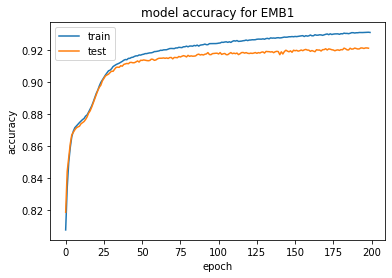

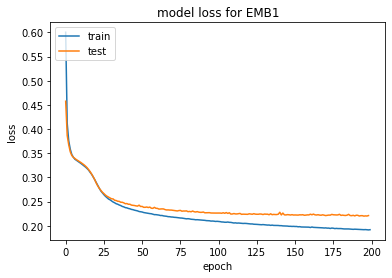

<Figure size 432x288 with 0 Axes>

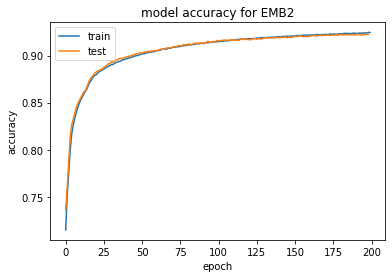

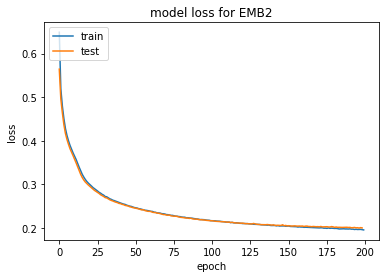

<Figure size 432x288 with 0 Axes>

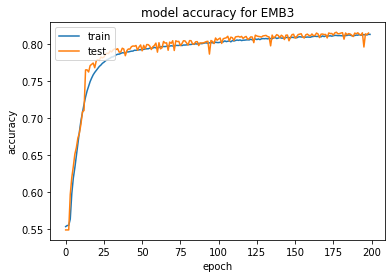

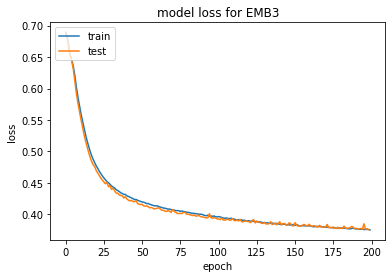

<Figure size 432x288 with 0 Axes>

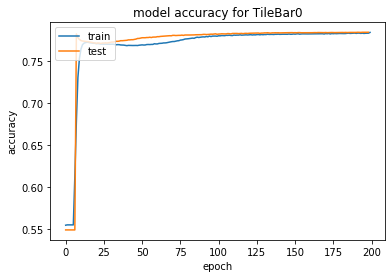

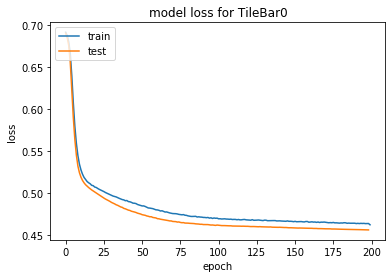

<Figure size 432x288 with 0 Axes>

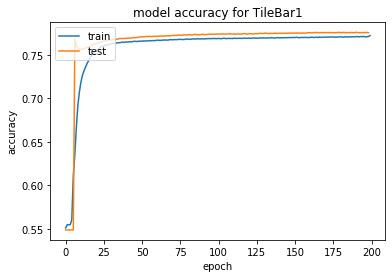

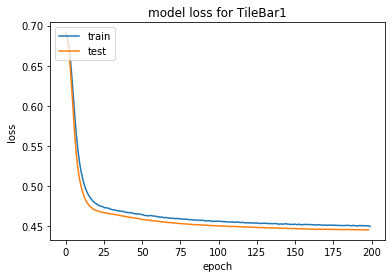

<Figure size 432x288 with 0 Axes>

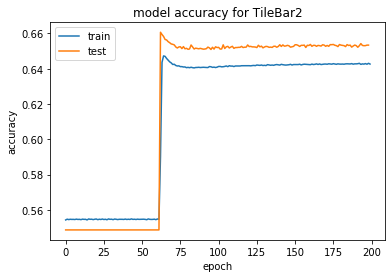

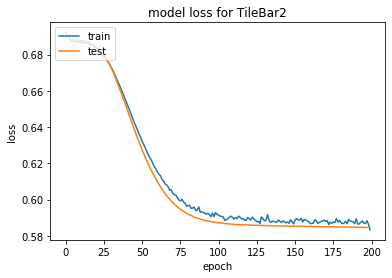

In [14]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_flat[layer_i].history['acc'])
    plt.plot(history_flat[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_flat[layer_i].history['loss'])
    plt.plot(history_flat[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
    plt.show()

In [6]:
from sklearn.metrics import roc_curve, auc

In [31]:
# roc curves, for all layers


y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1],drop_intermediate=False)
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.9704151956799698
Area under curve: 0.9749806134688982
Area under curve: 0.906359759392946
Area under curve: 0.8113248098562773
Area under curve: 0.7985339279672746
Area under curve: 0.6909958899956501


In [13]:
x_lc = np.append(1-p0['cluster_EM_PROBABILITY'],1 - pp['cluster_EM_PROBABILITY'])
y_lc = np.append(p0['label'], pp['label']) 

In [14]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.950805032076483


<Figure size 432x288 with 0 Axes>

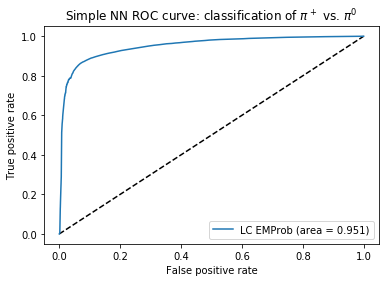

In [15]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

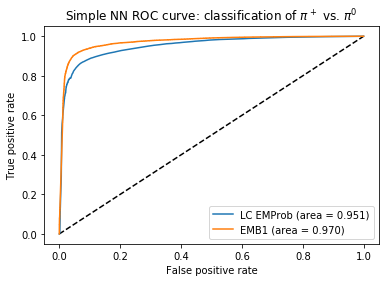

In [16]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_emb1_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

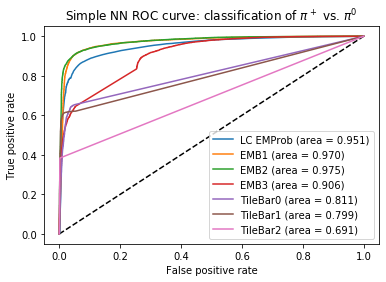

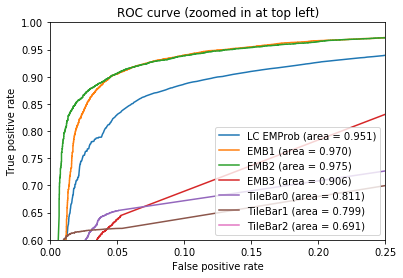

In [22]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


In [17]:
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))

y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 200, batch_size = 200*ngpu, verbose = 2)

Epoch 1/200
24000/24000 - 0s - loss: 0.6874 - acc: 0.5552
Epoch 2/200
24000/24000 - 0s - loss: 0.6611 - acc: 0.5552
Epoch 3/200
24000/24000 - 0s - loss: 0.6142 - acc: 0.5552
Epoch 4/200
24000/24000 - 0s - loss: 0.5403 - acc: 0.6576
Epoch 5/200
24000/24000 - 0s - loss: 0.4577 - acc: 0.8281
Epoch 6/200
24000/24000 - 0s - loss: 0.3835 - acc: 0.9117
Epoch 7/200
24000/24000 - 0s - loss: 0.3252 - acc: 0.9325
Epoch 8/200
24000/24000 - 0s - loss: 0.2795 - acc: 0.9400
Epoch 9/200
24000/24000 - 0s - loss: 0.2442 - acc: 0.9440
Epoch 10/200
24000/24000 - 0s - loss: 0.2174 - acc: 0.9451
Epoch 11/200
24000/24000 - 0s - loss: 0.1975 - acc: 0.9458
Epoch 12/200
24000/24000 - 0s - loss: 0.1836 - acc: 0.9469
Epoch 13/200
24000/24000 - 0s - loss: 0.1738 - acc: 0.9472
Epoch 14/200
24000/24000 - 0s - loss: 0.1673 - acc: 0.9478
Epoch 15/200
24000/24000 - 0s - loss: 0.1630 - acc: 0.9477
Epoch 16/200
24000/24000 - 0s - loss: 0.1599 - acc: 0.9483
Epoch 17/200
24000/24000 - 0s - loss: 0.1579 - acc: 0.9482
Epoch 

Epoch 140/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9489
Epoch 141/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9491
Epoch 142/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9492
Epoch 143/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9497
Epoch 144/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9490
Epoch 145/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9492
Epoch 146/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9490
Epoch 147/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9492
Epoch 148/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9495
Epoch 149/200
24000/24000 - 0s - loss: 0.1490 - acc: 0.9491
Epoch 150/200
24000/24000 - 0s - loss: 0.1490 - acc: 0.9492
Epoch 151/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9496
Epoch 152/200
24000/24000 - 0s - loss: 0.1489 - acc: 0.9492
Epoch 153/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9494
Epoch 154/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9492
Epoch 155/200
24000/24000 - 0s - loss: 0.1488 - acc: 0.9495
Epoch 156/200
24000/24000 - 0s - loss: 0

<Figure size 432x288 with 0 Axes>

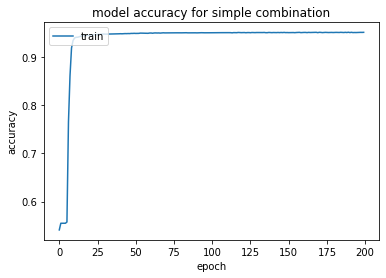

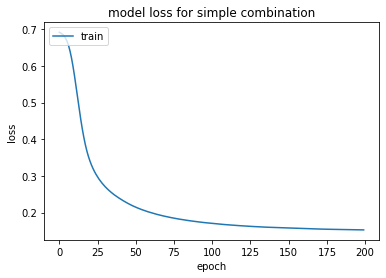

In [25]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'loss_simpleCombine.pdf')
    plt.show()
    

In [19]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print(auc_combined)

0.9817484453978564


<Figure size 432x288 with 0 Axes>

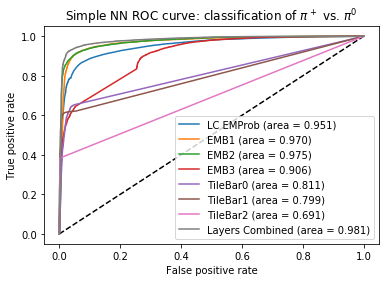

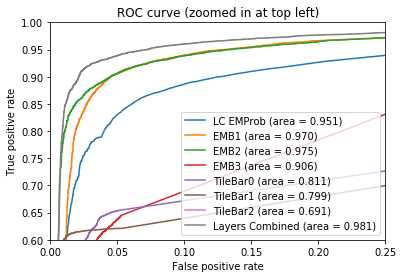

In [28]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_zoom_combine1_layers.pdf')
plt.show()


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [30]:
with strategy.scope():    

    model_combine = Sequential()

    #EMB1
    input1 = Input(shape=(512,), name = 'input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)

    #EMB2
    input2 = Input(shape=(256,), name = 'input2')
    x2 = Dense(256, activation='relu')(input2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)

    #EMB3
    input3 = Input(shape=(128,), name = 'input3')
    x3 = Dense(128, activation='relu')(input3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(64, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)

    #Tile0
    input4 = Input(shape=(16,), name = 'input4')
    x4 = Dense(16, activation='relu')(input4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(8, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(4, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)

    #Tile1
    input5 = Input(shape=(16,), name = 'input5')
    x5 = Dense(16, activation='relu')(input5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(8, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(4, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)

    #Tile2
    input6 = Input(shape=(8,), name = 'input6')
    x6 = Dense(8, activation='relu')(input6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(4, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(2, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)

    #Combination
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    output_combine = Dense(2, activation='softmax')(x)

    model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
    model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])   

In [31]:
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=200, batch_size=200*ngpu, verbose=2)

INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl,num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
Epoch 1/200
291/291 - 40s - loss: 0.5263 - acc: 0.8001 - val_loss: 0.3220 - val_acc: 0.8852
Epoch 2/200
291/291 - 13s - loss: 0.3178 - acc: 0.8873 - val_loss: 0.2884 - val_acc: 0.8991
Epoch 3/200
291/291 - 13s - loss: 0.2960 - acc: 0.8965 - val_loss: 0.2738 - val_acc: 0.9038
Epoch 4/200
291/291 - 13s - loss: 0.2823 - acc: 0.9003 - val_loss: 0.2604 - val_acc: 0.9056
Epoch 5/200
291/291 - 13s - loss: 0.2664 - acc: 0.9022 - val_loss: 0.2454 - val_acc: 0.9073
Epoch 6/200
291/291 - 13s - loss: 0.2525 - acc: 0.9053 - val_loss: 0.2359 - val_acc: 0.9144
Epoch 7/200
291/291 - 13s - loss: 0.2450 - acc: 0.9109 - val_loss: 0.2325 - val_acc: 0.9168
Epoch 8/200
291/291 - 13s - loss: 0.2397 - acc: 0.9147 - val_loss: 0.2273 - val_acc: 0.9197
Epoch 9/200
291/291 - 13s - loss: 0.2349 - acc: 0.9172 - val_loss: 0.2246 - val_acc: 0.9213
Epoch 10/200
291/291 

Epoch 88/200
291/291 - 13s - loss: 0.1458 - acc: 0.9508 - val_loss: 0.1524 - val_acc: 0.9482
Epoch 89/200
291/291 - 13s - loss: 0.1458 - acc: 0.9507 - val_loss: 0.1523 - val_acc: 0.9477
Epoch 90/200
291/291 - 13s - loss: 0.1452 - acc: 0.9511 - val_loss: 0.1537 - val_acc: 0.9476
Epoch 91/200
291/291 - 13s - loss: 0.1449 - acc: 0.9512 - val_loss: 0.1528 - val_acc: 0.9481
Epoch 92/200
291/291 - 13s - loss: 0.1445 - acc: 0.9515 - val_loss: 0.1520 - val_acc: 0.9475
Epoch 93/200
291/291 - 13s - loss: 0.1444 - acc: 0.9512 - val_loss: 0.1515 - val_acc: 0.9488
Epoch 94/200
291/291 - 13s - loss: 0.1442 - acc: 0.9514 - val_loss: 0.1518 - val_acc: 0.9487
Epoch 95/200
291/291 - 14s - loss: 0.1440 - acc: 0.9516 - val_loss: 0.1516 - val_acc: 0.9486
Epoch 96/200
291/291 - 13s - loss: 0.1438 - acc: 0.9516 - val_loss: 0.1504 - val_acc: 0.9491
Epoch 97/200
291/291 - 13s - loss: 0.1429 - acc: 0.9517 - val_loss: 0.1520 - val_acc: 0.9488
Epoch 98/200
291/291 - 13s - loss: 0.1429 - acc: 0.9517 - val_loss: 0.

Epoch 176/200
291/291 - 13s - loss: 0.1275 - acc: 0.9576 - val_loss: 0.1442 - val_acc: 0.9516
Epoch 177/200
291/291 - 13s - loss: 0.1283 - acc: 0.9572 - val_loss: 0.1439 - val_acc: 0.9517
Epoch 178/200
291/291 - 13s - loss: 0.1277 - acc: 0.9576 - val_loss: 0.1437 - val_acc: 0.9515
Epoch 179/200
291/291 - 13s - loss: 0.1273 - acc: 0.9576 - val_loss: 0.1438 - val_acc: 0.9511
Epoch 180/200
291/291 - 13s - loss: 0.1278 - acc: 0.9576 - val_loss: 0.1456 - val_acc: 0.9517
Epoch 181/200
291/291 - 13s - loss: 0.1273 - acc: 0.9576 - val_loss: 0.1428 - val_acc: 0.9518
Epoch 182/200
291/291 - 13s - loss: 0.1269 - acc: 0.9577 - val_loss: 0.1433 - val_acc: 0.9513
Epoch 183/200
291/291 - 13s - loss: 0.1272 - acc: 0.9576 - val_loss: 0.1437 - val_acc: 0.9515
Epoch 184/200
291/291 - 13s - loss: 0.1266 - acc: 0.9579 - val_loss: 0.1442 - val_acc: 0.9514
Epoch 185/200
291/291 - 13s - loss: 0.1265 - acc: 0.9580 - val_loss: 0.1432 - val_acc: 0.9518
Epoch 186/200
291/291 - 13s - loss: 0.1267 - acc: 0.9579 - v

In [32]:
model_combine.save(modelpath+"model_deep_do20.h5")

In [23]:
model_combine = tf.keras.models.load_model(modelpath+"model_deep_do20.h5")

<Figure size 432x288 with 0 Axes>

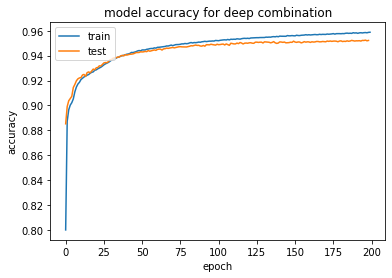

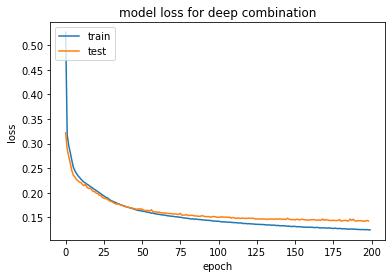

In [33]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/loss_deepCombine.pdf')
plt.show()


In [24]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.985854843117698


<Figure size 432x288 with 0 Axes>

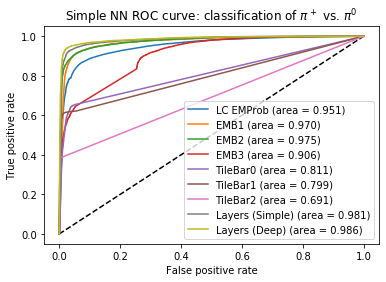

<Figure size 432x288 with 0 Axes>

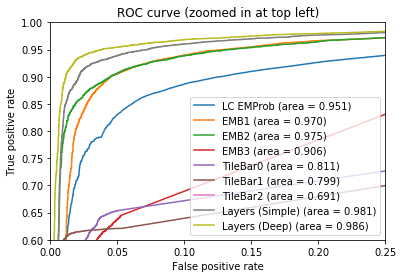

In [35]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_layers.pdf')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

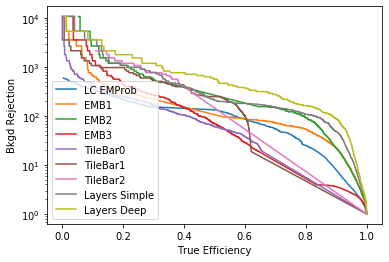

In [32]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.yscale('log')
plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
for layer_i, layer_name in enumerate(layers):
    plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
plt.plot(tpr_simpleCombine, 1/fpr_simpleCombine, label='Layers Simple')
plt.plot(tpr_combine, 1/fpr_combine, label='Layers Deep')
plt.legend(loc='best')
plt.xlabel('True Efficiency')
plt.ylabel('Bkgd Rejection')
plt.savefig(plotpath+'roc_reg_combine2_layers.pdf')
plt.show()


In [36]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<Figure size 432x288 with 0 Axes>

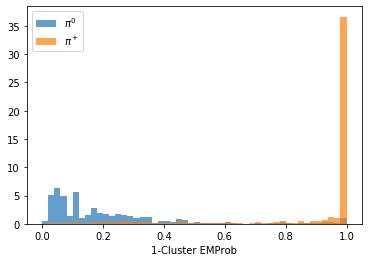

In [ ]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## 2. Convolutional Neural Network

In [33]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [37]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(468521, 1, 16, 16)
(468521, 1)
y_train.shape:  (468521, 1)
y_train_onehot.shape:  (468521, 2)


In [36]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [37]:
# split up into training and test datasets, using functions
test_size = 24000
validation_size = 24000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)
y_train.shape:  (425521, 1)
y_train_onehot.shape:  (425521, 2)


In [140]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [38]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [39]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

EMB1
4
128
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 3, 125)        288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 1, 62)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 1, 62)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               254080    
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 258       
Total params: 254,626
Trainable params: 254,626
Non-trainable params: 0
_____________________________________

In [83]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [84]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)             

In [ ]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=200, batch_size=200*ngpu, verbose=2)


On layer EMB1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl,num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
Epoch 1/200
532/532 - 21s - loss: 0.4526 - acc: 0.8068 - val_loss: 0.3961 - val_acc: 0.8366
Epoch 2/200
532/532 - 5s - loss: 0.3891 - acc: 0.8409 - val_loss: 0.3889 - val_acc: 0.8419
Epoch 3/200
532/532 - 5s - loss: 0.3822 - acc: 0.8455 - val_loss: 0.3820 - val_acc: 0.8454
Epoch 4/200
532/532 - 5s - loss: 0.3736 - acc: 0.8505 - val_loss: 0.3726 - val_acc: 0.8527
Epoch 5/200
532/532 - 5s - loss: 0.3624 - acc: 0.8558 - val_loss: 0.3595 - val_acc: 0.8595
Epoch 6/200
532/532 - 5s - loss: 0.3527 - acc: 0.8607 - val_loss: 0.3549 - val_acc: 0.8613
Epoch 7/200
532/532 - 5s - loss: 0.3452 - acc: 0.8648 - val_loss: 0.3434 - val_acc: 0.8668
Epoch 8/200
532/532 - 5s - loss: 0.3405 - acc: 0.8676 - val_loss: 0.3394 - val_acc: 0.8692
Epoch 9/200
532/532 - 5s - loss: 0.3355 - acc: 0.8696 - val_loss: 0.3359 - val_acc: 0.8698
Epoch 10/200
532

Epoch 89/200
532/532 - 5s - loss: 0.2693 - acc: 0.8968 - val_loss: 0.2799 - val_acc: 0.8956
Epoch 90/200
532/532 - 5s - loss: 0.2674 - acc: 0.8977 - val_loss: 0.2785 - val_acc: 0.8949
Epoch 91/200
532/532 - 5s - loss: 0.2682 - acc: 0.8974 - val_loss: 0.2797 - val_acc: 0.8943
Epoch 92/200
532/532 - 5s - loss: 0.2685 - acc: 0.8972 - val_loss: 0.2821 - val_acc: 0.8938
Epoch 93/200
532/532 - 5s - loss: 0.2678 - acc: 0.8976 - val_loss: 0.2779 - val_acc: 0.8962
Epoch 94/200
532/532 - 5s - loss: 0.2681 - acc: 0.8976 - val_loss: 0.2826 - val_acc: 0.8959
Epoch 95/200
532/532 - 5s - loss: 0.2667 - acc: 0.8978 - val_loss: 0.2777 - val_acc: 0.8950
Epoch 96/200
532/532 - 5s - loss: 0.2676 - acc: 0.8978 - val_loss: 0.2784 - val_acc: 0.8949
Epoch 97/200
532/532 - 5s - loss: 0.2674 - acc: 0.8978 - val_loss: 0.2800 - val_acc: 0.8935
Epoch 98/200
532/532 - 5s - loss: 0.2666 - acc: 0.8981 - val_loss: 0.2786 - val_acc: 0.8954
Epoch 99/200
532/532 - 5s - loss: 0.2661 - acc: 0.8980 - val_loss: 0.2816 - val_

Epoch 178/200
532/532 - 6s - loss: 0.2557 - acc: 0.9029 - val_loss: 0.2784 - val_acc: 0.8960
Epoch 179/200
532/532 - 6s - loss: 0.2543 - acc: 0.9029 - val_loss: 0.2739 - val_acc: 0.8980
Epoch 180/200
532/532 - 6s - loss: 0.2549 - acc: 0.9028 - val_loss: 0.2737 - val_acc: 0.8993
Epoch 181/200
532/532 - 5s - loss: 0.2553 - acc: 0.9025 - val_loss: 0.2758 - val_acc: 0.8978
Epoch 182/200
532/532 - 5s - loss: 0.2544 - acc: 0.9030 - val_loss: 0.2742 - val_acc: 0.8988
Epoch 183/200
532/532 - 6s - loss: 0.2548 - acc: 0.9027 - val_loss: 0.2751 - val_acc: 0.8990
Epoch 184/200
532/532 - 6s - loss: 0.2557 - acc: 0.9025 - val_loss: 0.2783 - val_acc: 0.8964
Epoch 185/200
532/532 - 6s - loss: 0.2547 - acc: 0.9029 - val_loss: 0.2759 - val_acc: 0.8975
Epoch 186/200
532/532 - 6s - loss: 0.2546 - acc: 0.9030 - val_loss: 0.2782 - val_acc: 0.8977
Epoch 187/200
532/532 - 5s - loss: 0.2544 - acc: 0.9028 - val_loss: 0.2733 - val_acc: 0.8984
Epoch 188/200
532/532 - 6s - loss: 0.2545 - acc: 0.9027 - val_loss: 0.

Epoch 64/200
532/532 - 6s - loss: 0.2500 - acc: 0.8990 - val_loss: 0.2540 - val_acc: 0.8969
Epoch 65/200
532/532 - 5s - loss: 0.2502 - acc: 0.8990 - val_loss: 0.2530 - val_acc: 0.8976
Epoch 66/200
532/532 - 6s - loss: 0.2496 - acc: 0.8990 - val_loss: 0.2521 - val_acc: 0.8982
Epoch 67/200
532/532 - 5s - loss: 0.2494 - acc: 0.8992 - val_loss: 0.2576 - val_acc: 0.8961
Epoch 68/200
532/532 - 5s - loss: 0.2493 - acc: 0.8992 - val_loss: 0.2524 - val_acc: 0.8988
Epoch 69/200
532/532 - 5s - loss: 0.2483 - acc: 0.8997 - val_loss: 0.2534 - val_acc: 0.8968
Epoch 70/200
532/532 - 5s - loss: 0.2489 - acc: 0.8997 - val_loss: 0.2507 - val_acc: 0.8984
Epoch 71/200
532/532 - 6s - loss: 0.2484 - acc: 0.9001 - val_loss: 0.2516 - val_acc: 0.8985
Epoch 72/200
532/532 - 6s - loss: 0.2486 - acc: 0.8998 - val_loss: 0.2518 - val_acc: 0.8992
Epoch 73/200
532/532 - 6s - loss: 0.2480 - acc: 0.8996 - val_loss: 0.2502 - val_acc: 0.8982
Epoch 74/200
532/532 - 5s - loss: 0.2477 - acc: 0.9001 - val_loss: 0.2502 - val_

Epoch 153/200
532/532 - 5s - loss: 0.2361 - acc: 0.9054 - val_loss: 0.2464 - val_acc: 0.9025
Epoch 154/200
532/532 - 6s - loss: 0.2364 - acc: 0.9050 - val_loss: 0.2474 - val_acc: 0.9017
Epoch 155/200
532/532 - 6s - loss: 0.2364 - acc: 0.9052 - val_loss: 0.2485 - val_acc: 0.9013
Epoch 156/200
532/532 - 5s - loss: 0.2365 - acc: 0.9052 - val_loss: 0.2475 - val_acc: 0.9025
Epoch 157/200
532/532 - 6s - loss: 0.2360 - acc: 0.9050 - val_loss: 0.2480 - val_acc: 0.9016
Epoch 158/200
532/532 - 5s - loss: 0.2364 - acc: 0.9053 - val_loss: 0.2472 - val_acc: 0.9033
Epoch 159/200
532/532 - 5s - loss: 0.2360 - acc: 0.9053 - val_loss: 0.2473 - val_acc: 0.9020
Epoch 160/200
532/532 - 6s - loss: 0.2358 - acc: 0.9055 - val_loss: 0.2472 - val_acc: 0.9017
Epoch 161/200
532/532 - 6s - loss: 0.2356 - acc: 0.9057 - val_loss: 0.2471 - val_acc: 0.9016
Epoch 162/200
532/532 - 6s - loss: 0.2354 - acc: 0.9057 - val_loss: 0.2478 - val_acc: 0.9010
Epoch 163/200
532/532 - 5s - loss: 0.2363 - acc: 0.9057 - val_loss: 0.

<Figure size 432x288 with 0 Axes>

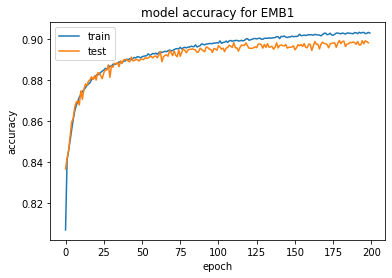

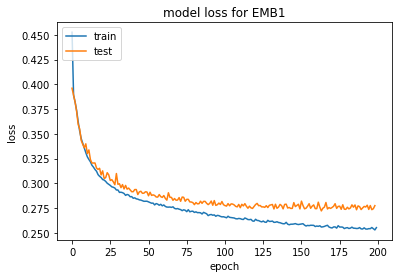

<Figure size 432x288 with 0 Axes>

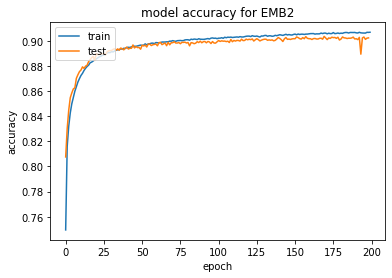

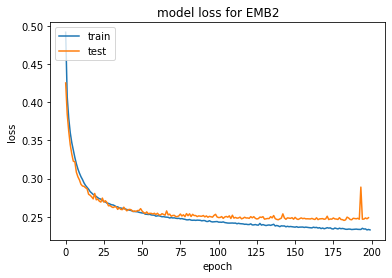

<Figure size 432x288 with 0 Axes>

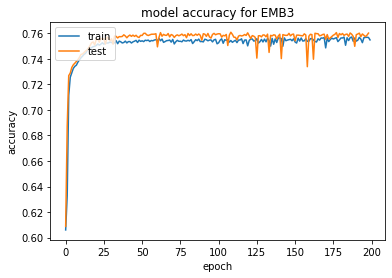

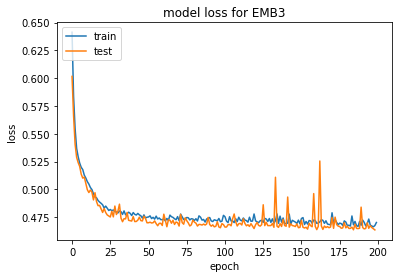

<Figure size 432x288 with 0 Axes>

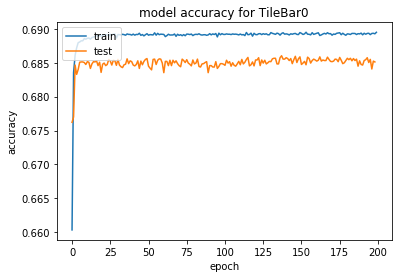

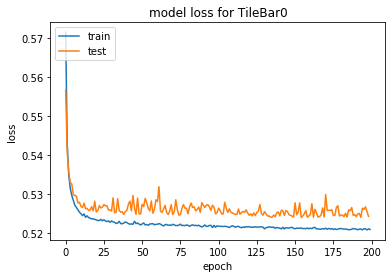

<Figure size 432x288 with 0 Axes>

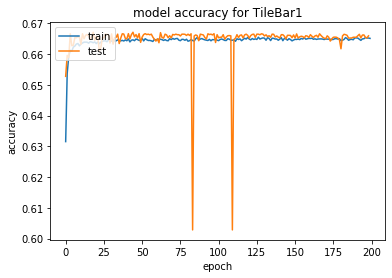

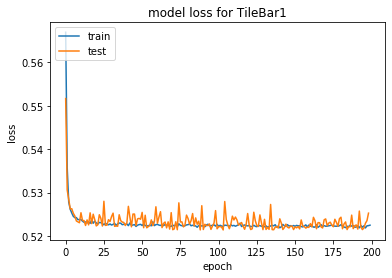

<Figure size 432x288 with 0 Axes>

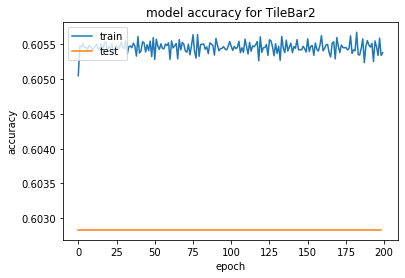

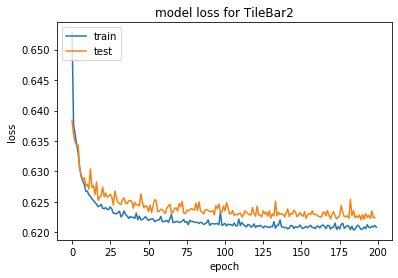

In [42]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

In [89]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

Train on 95000 samples, validate on 1000 samples
Epoch 1/40
 - 4s - loss: 0.3903 - accuracy: 0.8342 - val_loss: 0.3721 - val_accuracy: 0.8350
Epoch 2/40
 - 4s - loss: 0.3795 - accuracy: 0.8409 - val_loss: 0.3659 - val_accuracy: 0.8410
Epoch 3/40
 - 4s - loss: 0.3722 - accuracy: 0.8450 - val_loss: 0.3510 - val_accuracy: 0.8450
Epoch 4/40
 - 4s - loss: 0.3658 - accuracy: 0.8493 - val_loss: 0.3433 - val_accuracy: 0.8570
Epoch 5/40
 - 4s - loss: 0.3605 - accuracy: 0.8518 - val_loss: 0.3316 - val_accuracy: 0.8650
Epoch 6/40
 - 4s - loss: 0.3554 - accuracy: 0.8547 - val_loss: 0.3519 - val_accuracy: 0.8610
Epoch 7/40
 - 4s - loss: 0.3498 - accuracy: 0.8566 - val_loss: 0.3289 - val_accuracy: 0.8680
Epoch 8/40
 - 4s - loss: 0.3460 - accuracy: 0.8589 - val_loss: 0.3266 - val_accuracy: 0.8680
Epoch 9/40
 - 4s - loss: 0.3442 - accuracy: 0.8607 - val_loss: 0.3234 - val_accuracy: 0.8690
Epoch 10/40
 - 4s - loss: 0.3394 - accuracy: 0.8616 - val_loss: 0.3170 - val_accuracy: 0.8620
Epoch 11/40
 - 4s - 

In [90]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [93]:
y_baseline_pred = model_cnn_base.predict(X_te)
fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
auc_baseline = auc(fpr_baseline, tpr_baseline)
print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

Area under curve: 0.9482839437465216
Area under curve: 0.9426352090745941


In [43]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


Area under curve: 0.9486574076350677
Area under curve: 0.9605159508756631
Area under curve: 0.8230046229591856
Area under curve: 0.736457505219338
Area under curve: 0.7264892410519067
Area under curve: 0.586519029934403


In [45]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    model_cnn_base_layers[layer_i].save(modelpath+"model_{}_cnn_base.h5".format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


<Figure size 432x288 with 0 Axes>

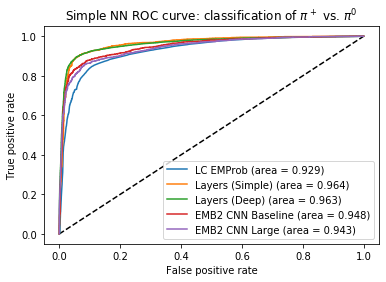

<Figure size 432x288 with 0 Axes>

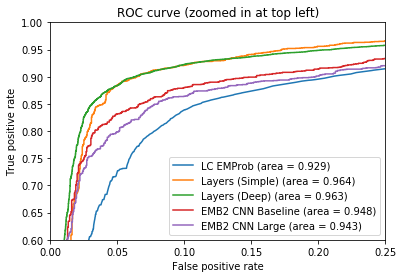

In [94]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

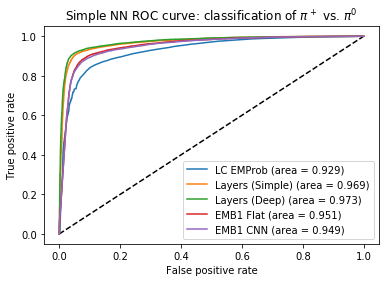

<Figure size 432x288 with 0 Axes>

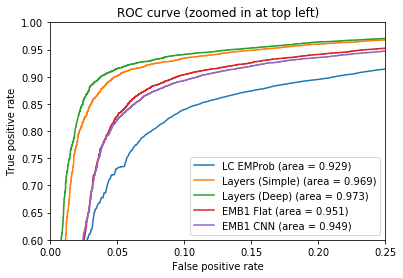

<Figure size 432x288 with 0 Axes>

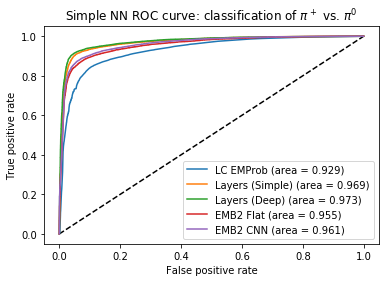

<Figure size 432x288 with 0 Axes>

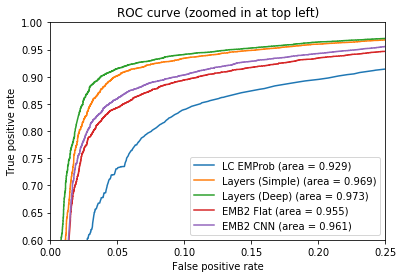

<Figure size 432x288 with 0 Axes>

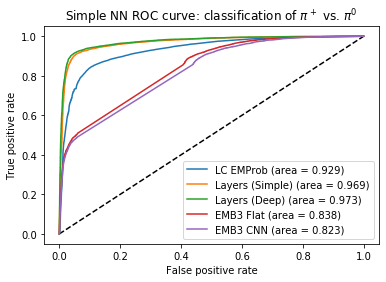

<Figure size 432x288 with 0 Axes>

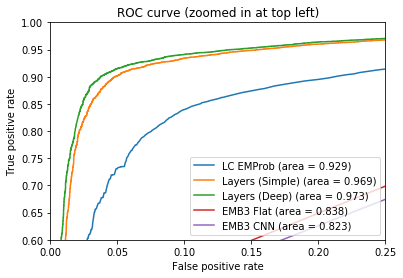

<Figure size 432x288 with 0 Axes>

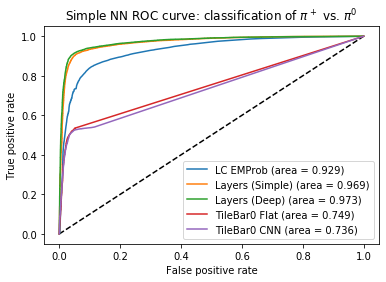

<Figure size 432x288 with 0 Axes>

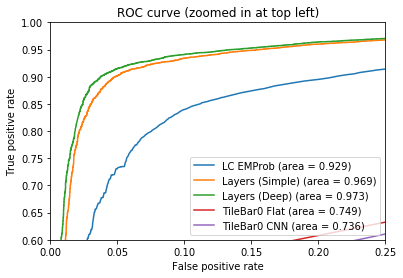

<Figure size 432x288 with 0 Axes>

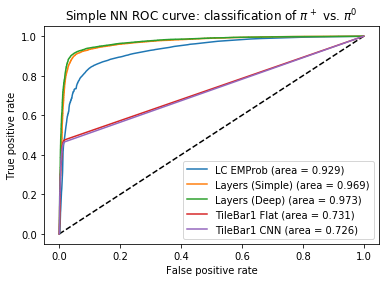

<Figure size 432x288 with 0 Axes>

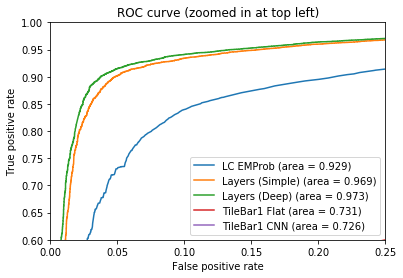

<Figure size 432x288 with 0 Axes>

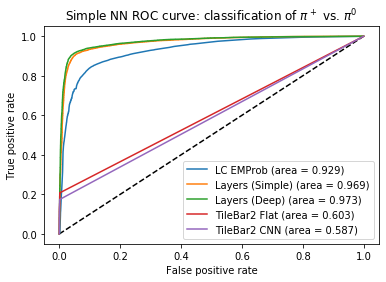

<Figure size 432x288 with 0 Axes>

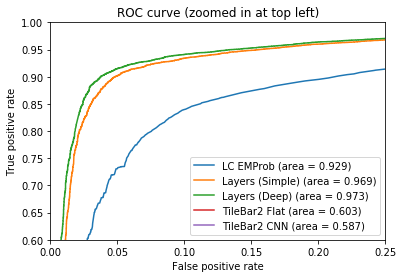

In [44]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

In [ ]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [ ]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

In [ ]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')